<a href="https://colab.research.google.com/github/mbrow20/BrowPSRepo/blob/master/Section_5_Recurrent_Neural_Networks%2C_Time_Series%2C_and_sequence_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 6. Sequence Data
Deep Learning originally become popular with images, then moved on to sequence data such as text, speech, financial data, etc.

Sequence as **time-series** signal that is type continuous taken periodically.
e.g., stock price.

##Airline passengers
Forecasting the amount of passengers you will have on your airline in any given month and given year.

###Makes sure airports have enough workers
###Uber can adjust prices based on demand
Old days of text recognition used 'bag-of-words' feature vector
###Document classification
Create a long feature vector (one feature for each word in the English language)
Inside vector, we count how many times a certain word/words were used. We
classify email as spam or not.

The feature vector for 'bag-of-words' is static, so each cell stands for a particular word. The counts then go into respective cells. The 'code' is the code for that text sequence, which leads to classification.

###Problem with 'bag-of-words' classification
When we only use word count, we lose information about the order of the words.
 For sequence data, we can think of this as N x D, but D = 1
 ### How do we represent the length in a sequence? N ? D?
 Neither. Think as **T**, which is sequence length

 ### Shape of Sequence: 3D...N x D x T





*   N: Number of Samples
*   D: Number of Features
*   T: Number of time steps in sequence.



### With GPS example, N may be the number of trips, D be number of latitude, longitude measurements, and T be the number of sequence steps recorded (e.g., lat, long measurements every second). For 30-minute trip you have 30 x 60 =1800 time points (or t).
In tensorflow and keras, only take equal length measurements.

Stock price is just a single feature, so D =1. Suppose we use of window of T = 10 to predict the next stock price.

N would be the number of windows in the time series we have (1-10 segment windows)
#### If you have sequence length of L, and a window size of T, L - T + 1 measurements or N


D can be more than 1, like, let's say, 500 stocks. So D = 500.

### Data order: N x T x D

#### Tabular data: N x D
#### Image data: N x H x W x C

(put features last)

### To make the sequences of equal length (e.g., the number of words in each sentence), keras will take the longest sentence as the standard, and pad the other sentences with '0' to make up for the length.

# Part 2: Forecasting

Forecast is to predict the next value in a time series
The number of future steps we want to predict is known as the horizon.
**Usually do not want to just forecast one step ahead**

#### Since forecasting has only one dimension (D = 1), we can flatten our N x T x D into a N x T x 1, or simply N x T

If we have a time series of length 10, and want to predict the next 3 values, then the input matrix (X) will be N X 3, and target (Y) will be of size (shape) N (N is the number of length-3 time windows that fit into the time series).

#### Is N, 10 - 3 + 1 = 8? Actually we have N = 4, because the length of window need to be 4, since we need to predict the next in the time series of length 3 (hence 4). The 4th value is the target.

This is an **autoregressive** (AR) model

The model is:
$$\hat{x}_t = w_0 + w_1x_{t-1} + w_2x_{t-2}+w_3x_{t-3}$$

### What if we want to predict multiple days ahead?

*   We want to predict Day 4, Day 5, Day 6, from Day 1, Day 2, Day 3
  * Can use Day 1, Day 2, and Day 3 to predict Day 4
  * Cannot use these values to predict Day 5 , since we do not know Day 4
  * Same goes for Day 6

### In order to make predictions for mulitple steps in the future, we must use earlier predictions as input

$$\hat{x_4} = w_0 + w_1x_3 + w_2x_2 + w_3x_1$$
$$\hat{x_5} = w_0 + w_1\hat{x_4} + w_2x_3 + w_3x_2$$
$$\hat{x_6} = w_0 + w_1\hat{x_5} + w_2\hat{x_4} + w_3x_3$$

###Need a loop, and call **model.predict()** only on the most recently generated sequence.

x = last value of training set

predictions= [] #instantiate empty array
```
for i in range(length(forecast)):
  x_next: model.predict(x)
  predictions.append(next_x)
  x = concat(x[1,:], x_next)
```

the **x** in the last line of the loop will have the next values of x, plus the prediction **x_next**. It will discard old predictions with **predictions.append(next_x)**.

Regular linear regression:

i = Input(shape=(T,))

x = Dense(1)(i)

model = Model(i,x)

**ANN**

i = Input(shape=(T,))

x = Dense(10, activation = 'relu')(i)

x = Dense(1)(x)

model = Model(i, x)








# Part 3: Autoregressive linear models for time series predictions



In [ ]:
!pip install  --upgrade tensorflow



In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#Make synthetic data
series = np.sin(0.1 * np.arange(200))
series

In [ ]:
#Plot it. This series has no noise
plt.plot(series)
plt.show()

In [ ]:
#Build the data set
T = 10 #which means, we will use 10 previous time steps to predict the next time step
X = []
Y = []
#populate X and Y as lists, and cast them to arrays once we are done

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, "Y.shape: ", Y.shape)
X[1:10,1]
#This has 190 segments of size 10. Series is 200 minus 10 targets (190)

X.shape:  (190, 10) Y.shape:  (190,)


array([0.19866933, 0.29552021, 0.38941834, 0.47942554, 0.56464247,
       0.64421769, 0.71735609, 0.78332691, 0.84147098])

In this loop, we go from zero up to the length of the series minus **T**. We know that our input X will go from little **t** (the first index) until little **t** plot big **T**, so, for example, 0 until 10. In terms of real indices, this is 0 to 9, inclusive. Actually, does not include index 10, but the target will be at index 10. We know that the final index of the original index series will be the final target, that is the index, **len(series)-1**. 

```
Final target index =Final t + T
=[len(series)-T-1] + T
= len(series) -1
```


In [ ]:

#Try out code
#T = 10 #which means, we will use 10 previous time steps to predict the next time step
#X = []
#Y = []
#populate X and Y as lists, and cast them to arrays once we are done

#for t in range(len(series) - T):
  #x = series[t:t+T]
  #X.append(x)
  #y = series[t+T]
  #Y.append(y)
#len(X)
#X[1:10]
#Y[1:10]


In [ ]:
#try autoregressive model
i = Input(shape =(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr = 0.1),
)


In [ ]:
#train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs = 80,
    validation_data = (X[-N//2:],
                       Y[-N//2:]),
)
#trains on the first half of the data set, and predicts on second half. Be careful of using package ways to split data

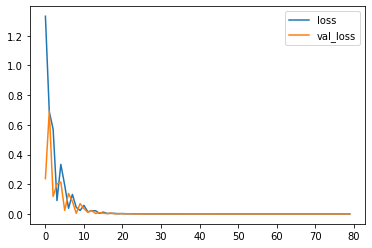

In [ ]:
#plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

In [ ]:
#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T (10 observations)
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0] #scalar
  #update predictions
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p
  
  
  

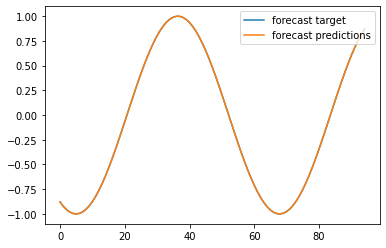

In [ ]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predictions')
plt.legend()

2.3.0


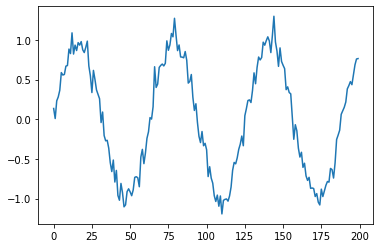

X.shape:  (190, 10) Y.shape:  (190,)
Epoch 1/80
3/3 [==============================] - 0s 29ms/step - loss: 0.1381 - val_loss: 0.0969
Epoch 2/80
3/3 [==============================] - 0s 7ms/step - loss: 0.1032 - val_loss: 0.0553
Epoch 3/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0994 - val_loss: 0.0402
Epoch 4/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0738 - val_loss: 0.0789
Epoch 5/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0542 - val_loss: 0.0500
Epoch 6/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0650 - val_loss: 0.0316
Epoch 7/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0492 - val_loss: 0.0389
Epoch 8/80
3/3 [==============================] - 0s 8ms/step - loss: 0.0450 - val_loss: 0.0342
Epoch 9/80
3/3 [==============================] - 0s 8ms/step - loss: 0.0468 - val_loss: 0.0258
Epoch 10/80
3/3 [==============================] - 0s 7ms/step - loss: 0.0437 - val_loss: 0.0329
E

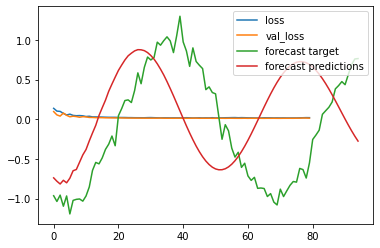

In [ ]:
#now we are going to add noise to the data signal
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Make synthetic data (with noise)
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

#Plot it. This series has no noise
plt.plot(series)
plt.show()

#Build the data set (noisy data set)
T = 10 #which means, we will use 10 previous time steps to predict the next time step
X = []
Y = []
#populate X and Y as lists, and cast them to arrays once we are done

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, "Y.shape: ", Y.shape)
X[1:10,1]
#This has 190 segments of size 10. Series is 200 minus 10 targets (190)

#try autoregressive model
i = Input(shape =(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr = 0.1),
)

#train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs = 80,
    validation_data = (X[-N//2:],
                       Y[-N//2:]),
)
#trains on the first half of the data set, and predicts on second half. Be careful of using package ways to split data

#plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T (10 observations)
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0] #scalar
  #update predictions
  validation_predictions.append(p)

  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predictions')
plt.legend()



# Part 4: Autoregression (Linear Regression)

###AR(2) Autoregressive of the Second Order

*  It is possible to predict a sine wave using only two previous values
*  This is an AR(2) model
*  No bias term is needed
$$x(t) = w_1x(t-1) + w_2x(t-2)$$

###Create sine wave as function of time

*  np.sin(0.1 * np.arange(200))
*  np.arange(200) is all the different values of $t$
*  0.1 is $\omega$, angular frequency
$$x(t) =sin(\omega t)$$

### Plug in sine wave function

*  Replace $x(t)$ with $sin(\omega t)$
*  Note Fibonacci is another recurrence relation where weights are...

    * Fi(n) = fib(n-1) + Fib(n-2)

$$x(t) = w_1x(t-1) + w_2x(t-2)$$
$$x(t+1) = w_1x(t) +w_2x(t-1)$$
$$sin(\omega (t+1)) = w_1 sin(\omega t)+w_2 sin(\omega (t-1))$$

### Multiply out $\omega$ 

$$sin(\omega (t+1)) = w_1 sin(\omega t)+w_2 sin(\omega (t-1))$$
$$sin( \omega t + \omega) = w_1sin(\omega t) + w_2 sin(\omega t - \omega)$$

### Use Trigometric Identities

$$sin(a+b) + sin(a-b) = 2 cos(b) sin(a)$$
(manipulate above equation)

$$sin(\omega t + \omega) - w_2sin(\omega t - \omega) = w_1sin(\omega t)$$

$$\omega t = a$$
$$\omega = b$$
Also
$$w_1 = 2cos(b), \hspace{3mm} \text{or} \hspace{2mm} 2cos(\omega)$$
$$w_2 = -1$$



# Part 5. Recurrent Neural Networks

What if D is more than one? That is, you have more than one time series data (stocks, rather than stock, or companies, rather than company).

*  Flatten the T x D times series into a single feature vector
  * 5 electrodes recording 100 time steps -> 500-length vector

## Recall ANN
Where hidden feature vector is calculated from the input vector, and the output is calculated from the hidden vector:

$$h = \sigma(W_h^Tx + b_h)$$
$$\hat{y} = \sigma(W_o^Th + b_o)$$

$h$ is hidden vector, $o$ is output vector.

##For RNN, make the hidden vector now depend on its previous hidden state

*  Linear regression forecasting: output is a linear function of inputs
*  Now: hidden state is a non-linear function of input and past hidden state
   * What kind of nonlinear function? Neuron.

$$h_t = \sigma(W_{xh}^Tx_t + W_{hh}^Th_{t-1}+b_h)$$
$$\hat{y_t} = \sigma (W_o^Th_t + b_o)$$

*  x= input
*  h = hidden
*  o = output
*  xh = input-to-hidden
*  hh = hidden-to-hidden

##How do we calculate?

*  Assume we are given input vectors: $x_1, x_2, \ldots, x_T$
*  Each individual $x_t$ is a vector of size D (Shape($x_t$) = D)
*  This entire data would be stored as a matrix of T x D
*  From $x_1$ (the first sequence vector) we can calculate $h_1$.
$$h_1 = \sigma (W_{xh}^Tx_1 + W_{hh}^Th_o + b_h)$$

*  $h_1$ dependes on $h_o$, but what is $h_o$? This is the initial hidden state. This is usually set to zero in most circumstances.

*  With $h_1$ we can calculate $\hat{y_1}$:
$$\hat{y_1} = \sigma(W_0^Th_1 + b_o)$$


*  Now we consider the 2nd input vector $x_2$. From this we can calculate $h_2$. calcuate the 2nd output.
$$h_2 = \sigma ( W_{xh}^Tx_2 + W_{hh}^Th_1 + b_h)$$
$$\hat{y_2} = \sigma(W_o^Th_2+b_o)$$

*  All the $\hat{y}$'s except the final $\hat{y}$, which is $\hat{y}_T$. Therefore, $\hat{y}_T$ gives us the final prediction, and all the other $\hat{y}$'s are discarded.
$$\hat{y}_T = f(x_1, x_2, \ldots, x_T)$$

##Classification Probability
For ANN and CNN, output is the probability of each category (k) given x:

$$p(y = k|x)$$

For RNNs, 
$$p(y_1 = k|x_1)$$
$$p(y_2 = k|x_1, x_2)$$
$$p(y_3 = k|x_1, x_2, x_3)$$
$$\cdots$$
$$p(y_T = k|x_1, x_2, \ldots, x_T)$$

###Relationship to Markov Models

*  The Markov assumption is that the current value only depends on the immdediately previous value

   * e.g., the next word only depends on the immediately preceding word, and nothing else.

##Writing Pseudo-code to produce $\hat{y}$ at each time.

```
Given the following:

W_{xh} = input to hidden weight
W_{hh} = hiddent to hidden weight
b_h = hidden bias
W_o = hidden to output weight
b_o = output bias
X = T x D  input matrix

tanh hidden activation
softmax ouput activation

Yhat = []
h_last = 0
for t in range(T):
  h_t = tanh(X[t].dot(W_x) + h_last.dot(W_h) + b_h)
  yhat = softmax(h_t.dot(W_o)+b_o)
  Yhat.append(yhat)
  #update h_last
  h_last = h_t
```

##Here are some RNN calculations

*  T = 100 (number of input vectors)
*  D = 10
*  M = 15 (number of hidden layers)

$W_{xh}$ (input to hidden) = D x M = 10 x 15 = 150.
$W_{hh}$ (hidden to hidden) = M x M = 15 x 15 = 225
$W_o$ (hidden to output) = M x K = 15 x 1 = 15










# Part 6. RNN Code Preparation

Simple RNN Code Preparation (just the name of the model)

###Steps:

* Step 1: load in the data
  * same as before, but not the right shape for our RNN (N x T x D)
* Step 2: Build Model
* Step 3: Train Model
* Step 4: Evaluate Model
* Step 5: Make prediction
  * need to pay attention to shapes

###Load in Data
* From a sine wave (with and without noise) create a supervised learning dataset
  * Input: sequence of length T
  * Next value (scalar)
* Count from $t = 0, \ldots$len(series)-T
  * since final target should be at len(series)-1
* Linear Regression expects 2-D input
  * we pass in N x T array
* RNN expects 3-D input, N x T x D 
  * we pass N x T x 1


In [ ]:
#Instantiate the model
#from tensorflow.keras.layers import Input, SimpleRNN, Dense
#i = Input(shape =(T,1))
#x = SimpleRNN(5, activation = 'relu')(i)
#x = Dense(1)(x)
#model = Model(i, x)

#Train and evaluate model
#model.compile(loss = 'mse',
              #optimizer = Adam(lr = 0.1))

#train RNN
#r = model.fit(
    #X[:-N//2],Y[:-N//2],
    #epochs = 80,
    #validation_data = (X[-N//2:],Y[-N//2:])
#)



### Make predictions

*  Input shape will be N x T x D (N is number of samples, T is the sequence length of vector, and D is number of features), output shape will be N X K
   * N =1, D =1, K =1
*  A single time-series input will be a 1-D array of length T
```
model.predict(x.reshape(1, T, 1))[0,0] #the number of samples is 1, and the
#number of features is 1
```


# Part 7: RNN for Times Series Prediction



In [ ]:
!pip install  --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)
2.3.0


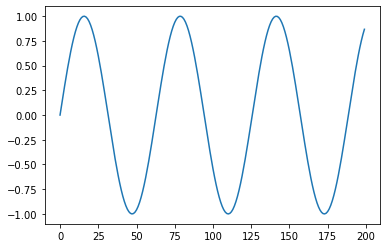

In [ ]:
#Create data which is sine wave with optional noise (first without noise)
series = np.sin(0.1 * np.arange(200)) #+ np.random.randn(200) * 0.1

#Plot it
plt.plot(series)
plt.show()

In [ ]:
#New code to save data as .csv
from numpy import savetxt

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)
data = X
Y = np.array(Y).reshape(-1, T)
Y.shape

 
Y.tofile('dataY.csv', sep = ' ')
savetxt('dataX.csv', data, delimiter=',')
np.savetxt(r"C:\Users\mbrow\OneDrive\Desktop\NewFolder\dataX.csv",data)
np.savetxt('dataY.csv', Y, delimiter=',')


from google.colab import files
files.download('dataX.csv')
files.download('dataY.csv')



In [ ]:
#create supervised learning data: N x T x D input, and N-length target
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) #Now data is N x T x D. -1 is wildcard so it makes sure the last dimensions are T and 1
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, "Y.shape: ", Y.shape)
#X[1,:,:]




X.shape:  (190, 10, 1) Y.shape:  (190,)


In [ ]:
!# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/My Drive/'

In [ ]:
#Build autoregressive RNN model
i = Input(shape = (T,1))
x = SimpleRNN(5, activation = None)(i)#try to set activation = None instead of 'relu'
#could run default 10h; x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr = 0.1)
)

#train RNN. Validation data for forecasting should include future data points.
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs = 80,
    validation_data = (X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
3/3 [==============================] - 0s 59ms/step - loss: 2.1617 - val_loss: 0.7547
Epoch 2/80
3/3 [==============================] - 0s 9ms/step - loss: 0.7030 - val_loss: 0.6925
Epoch 3/80
3/3 [==============================] - 0s 9ms/step - loss: 0.5572 - val_loss: 0.4949
Epoch 4/80
3/3 [==============================] - 0s 9ms/step - loss: 0.4957 - val_loss: 0.5095
Epoch 5/80
3/3 [==============================] - 0s 10ms/step - loss: 0.3610 - val_loss: 0.2194
Epoch 6/80
3/3 [==============================] - 0s 9ms/step - loss: 0.1789 - val_loss: 0.1339
Epoch 7/80
3/3 [==============================] - 0s 8ms/step - loss: 0.0948 - val_loss: 0.0371
Epoch 8/80
3/3 [==============================] - 0s 8ms/step - loss: 0.0271 - val_loss: 0.0102
Epoch 9/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0188 - val_loss: 0.0242
Epoch 10/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0382 - val_loss: 0.0185
Epoch 11/80
3/3 [====================

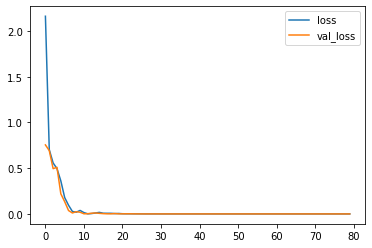

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

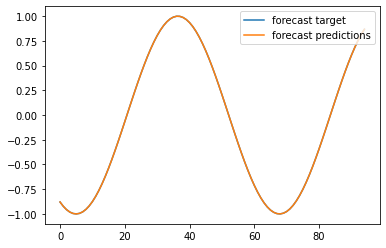

In [ ]:
#Wrong forecasting using true targets
#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#index of first validation input
i = -N//2 
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1,1))[0,0] #1 x 1 array - scalar
  #update predictions
  validation_predictions.append(p)
  i += 1

plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast predictions")
plt.legend()

 

In [ ]:
#Right way for forecasting: Use only self-predictions for making future predictions (not actual data)
#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T (10 observations)
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1, 1))[0,0] #scalar
  #update predictions
  validation_predictions.append(p)
  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


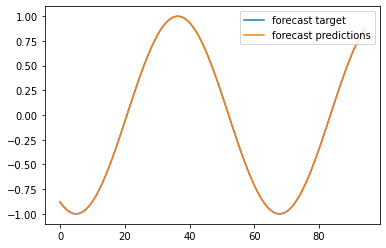

In [ ]:

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predictions')
plt.legend()

#### An RNN with no activations is a linear model, and we know that an AR(2) will model the sine wave perfectly.


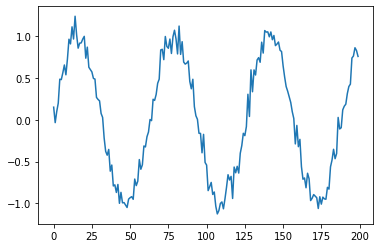

In [ ]:
###Add noise to the data set
#Create data which is sine wave with optional noise (first without noise)
series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1

#Plot it
plt.plot(series)
plt.show()

In [ ]:
#create supervised learning data: N x T x D input, and N-length target
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1) #Now data is N x T x D. -1 is wildcard so it makes sure the last dimensions are T and 1
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, "Y.shape: ", Y.shape)
#X[1,:,:]

X.shape:  (190, 10, 1) Y.shape:  (190,)


In [ ]:
#Build autoregressive RNN model
i = Input(shape = (T,1))
x = SimpleRNN(5, activation = 'relu')(i)#try to set activation = None instead of 'relu'. Default is 'tanh'
#could run default 10h; x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(lr = 0.1)
)

#train RNN. Validation data for forecasting should include future data points.
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs = 80,
    validation_data = (X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
3/3 [==============================] - 0s 64ms/step - loss: 0.9791 - val_loss: 0.7222
Epoch 2/80
3/3 [==============================] - 0s 9ms/step - loss: 0.7050 - val_loss: 0.5888
Epoch 3/80
3/3 [==============================] - 0s 9ms/step - loss: 0.5768 - val_loss: 0.5112
Epoch 4/80
3/3 [==============================] - 0s 9ms/step - loss: 0.4804 - val_loss: 0.4814
Epoch 5/80
3/3 [==============================] - 0s 10ms/step - loss: 0.4017 - val_loss: 0.4006
Epoch 6/80
3/3 [==============================] - 0s 10ms/step - loss: 0.3253 - val_loss: 0.3508
Epoch 7/80
3/3 [==============================] - 0s 12ms/step - loss: 0.2264 - val_loss: 0.2790
Epoch 8/80
3/3 [==============================] - 0s 9ms/step - loss: 0.2091 - val_loss: 0.2210
Epoch 9/80
3/3 [==============================] - 0s 10ms/step - loss: 0.1414 - val_loss: 0.1453
Epoch 10/80
3/3 [==============================] - 0s 10ms/step - loss: 0.1168 - val_loss: 0.1212
Epoch 11/80
3/3 [================

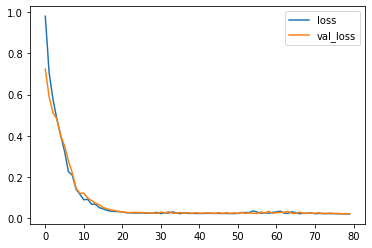

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

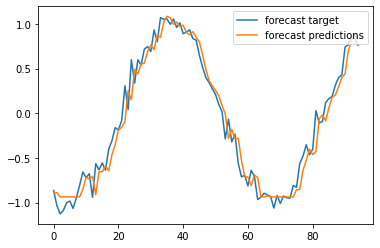

In [ ]:
#Wrong forecasting using true targets
#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#index of first validation input
i = -N//2 
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1,1))[0,0] #1 x 1 array - scalar
  #update predictions
  validation_predictions.append(p)
  i += 1

plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast predictions")
plt.legend()

In [ ]:
#Right way for forecasting: Use only self-predictions for making future predictions (not actual data)
#Forecast future values(use only self-predicted values)
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T (10 observations)
 
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1, 1))[0,0] #scalar
  #update predictions
  validation_predictions.append(p)
  #make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

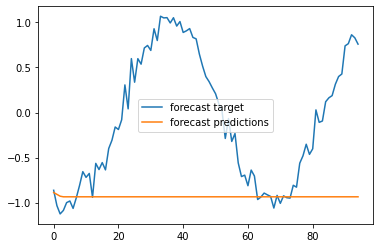

In [ ]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast predictions')
plt.legend()

# Part 8. Tracking the Shapes of RNNs



In [ ]:
!pip install  --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###Remember this notation for RNN

*  N = number of samples
*  T = sequence length (of time series, eg)
*  D = number of input features
*  M = number of hidden units
*  K = numer of output units

In [ ]:
#Make some data
N = 1
T = 10
D = 3
K = 2
X = np.random.randn(N, T, D) #X is a random array of N x T x D

In [ ]:
#Make RNN
M = 5 #number of hidden units
i = Input(shape = (T, D))
x = SimpleRNN(M)(i) #default activation is 'tanh'
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
# get output
Yhat = model.predict(X)
print(Yhat)

[[-0.11633443  0.5646189 ]]


In [ ]:
#Do model summary to see all the layers
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 5)                 45        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 12        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# See what's returned
model.layers[1].get_weights()

[array([[ 0.54360896, -0.62074965, -0.2701283 , -0.79017746,  0.38300878],
        [ 0.13730377, -0.24165744, -0.00981838,  0.2804814 , -0.6883804 ],
        [ 0.2773587 , -0.4808015 , -0.1695674 , -0.5702467 ,  0.18978661]],
       dtype=float32),
 array([[ 0.6243812 ,  0.07631569,  0.1355058 , -0.2320979 , -0.72944695],
        [-0.3203365 ,  0.07251319, -0.8532246 , -0.1280355 , -0.38437107],
        [-0.6816467 ,  0.28846344,  0.490396  , -0.26024485, -0.37938246],
        [ 0.06572596, -0.1750724 , -0.0465287 , -0.92622036,  0.32400733],
        [ 0.1963938 ,  0.9354445 , -0.10484692, -0.06423421,  0.266935  ]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32)]

In [ ]:
#More helpful to get shapes of weight arrays to see what corres. to what
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)
# the first weight is a D x M, which means it is the input to hidden layers, the second
# is M x M, which is the hidden to hidden weight, and the third is M which is the biased term

(3, 5) (5, 5) (5,)


In [ ]:
Wx, Wh, bh = model.layers[1].get_weights()
Wo, bo = model.layers[2].get_weights() #2nd layer is output layer

In [ ]:
h_last = np.zeros(M)
x = X[0]
Yhats = []

for t in range(T):
  h = np.tanh(x[t].dot(Wx)+h_last.dot(Wh)+bh)
  y = h.dot(Wo) + bo 
  Yhats.append(y)

  #updae h_last
  h_last = h 

print(Yhats[-1]) #final value


[-0.11633451  0.56461887]


In [ ]:
# Make data with two samples
#Make some data
N = 2
T = 10
D = 3
K = 2
X = np.random.randn(N, T, D) #X is a random array of N x T x D

In [ ]:
#Make RNN
M = 5 #number of hidden units
i = Input(shape = (T, D))
x = SimpleRNN(M)(i) #default activation is 'tanh'
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
# get output
Yhat = model.predict(X)
print(Yhat[0])

[ 0.3912936  -0.31761998]


In [ ]:
#Do model summary to see all the layers
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 10, 3)]           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 5)                 45        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# See what's returned
model.layers[1].get_weights()

[array([[ 0.03104621,  0.36803347,  0.49781042,  0.48316997,  0.6485899 ],
        [ 0.54895324, -0.7942816 ,  0.6733144 ,  0.05603796, -0.80717564],
        [-0.22904754,  0.5711085 ,  0.70165914, -0.78710985, -0.4033038 ]],
       dtype=float32),
 array([[ 0.27536166,  0.24768166, -0.54116815,  0.7538924 ,  0.04016317],
        [-0.02774555,  0.33583158, -0.49433848, -0.41865215, -0.6832329 ],
        [ 0.63856304, -0.40822262, -0.40344507, -0.40544164,  0.3137526 ],
        [-0.16858776, -0.8064296 , -0.10497173,  0.27691308, -0.48326957],
        [-0.69801265, -0.09432138, -0.53756815, -0.12374485,  0.4467544 ]],
       dtype=float32),
 array([0., 0., 0., 0., 0.], dtype=float32)]

In [ ]:
#More helpful to get shapes of weight arrays to see what corres. to what
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)
# the first weight is a D x M, which means it is the input to hidden layers, the second
# is M x M, which is the hidden to hidden weight, and the third is M which is the biased term

(3, 5) (5, 5) (5,)


In [ ]:
Wx, Wh, bh = model.layers[1].get_weights()
Wo, bo = model.layers[2].get_weights() #2nd layer is output layer

In [ ]:
for n in range(N):
  h_last = np.zeros(M)
  x = X[n]
  Yhats = []

  for t in range(T):
    h = np.tanh(x[t].dot(Wx)+h_last.dot(Wh)+bh)
    y = h.dot(Wo) + bo 
    Yhats.append(y)

    #updae h_last
    h_last = h 
  print(Yhats[-1]) #final value


[ 0.39129357 -0.31761995]
[-0.1475586 -0.5499325]
